Class

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sys import stdout
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from matplotlib.ticker import MaxNLocator
from sklearn.cross_decomposition import PLSRegression

class fixed_size_GA():

    def __init__(self,N:100,m:10, crossp=0.7,mutp = 0.7):
        '''
        Parameters:
        N (int) Number of individuals per population (population size).
        m (int): Number of fixed components.
        crossp (float) crossover probability.
        mutp (float) mutation probability.
        '''
        self._N = N
        self._m = m
        self._crossp = crossp
        self._mutp = mutp
        
        self._NEGNRMSEPiqrscorer = make_scorer(self._NEGNRMSEPiqr)
        
        df = pd.read_excel("datasets/Dataset_2.xlsx",sheet_name="preproc")
        self._X = (df.iloc[:,14:]).values
        self._Y = (df.iloc[:,7]).values
        self._n = self._X.shape[1]
        random_cv = np.random.seed(777)
        self._trials = 100
        self._seeds = np.random.choice(self._trials + 1, size=self._trials, replace= False)


        self._create_initial_population()

    def _create_initial_population(self):
        """
        This function create the initial pseudorandom population with
        a fixed size of 1s..

        Parameters:

        Returns:
        Initial population (list): list of bit string consisting of the initial population 
        """
        C = np.zeros((self._N,self._n),dtype=int)
        for i in range(self._N):
            I = np.random.permutation(np.arange(self._n))[:self._m]
            C[i][I] = 1

        
        self._population = self._compute_fitness_list(C)
        self._order_population()

    def get_population(self):
        return[individual for individual in self._population]
           
    def _check(self,X,P1,P2):
        '''
        Algorithm used to maintain a costant number of components selected
        after crossover or mutation

        Parameters:
        X (list): offspring index array
        P1 (list): first parent index array
        P2 (list): second parent index array

        Returns:
        X (list): checked offspring index array
        '''


        C = np.zeros(self._n, dtype=int)
        for h in range(len(X)):
            C[X[h]] = 1

        if sum(C) < self._m:
            X_new = np.sort(X)
            A = np.concatenate((P1,P2))
            D = np.setdiff1d(A ,X_new)
            I = np.random.permutation(np.arange(len(D)))
            k = 0
            for h in range(len(X) - 1):
                if X_new[h] == X_new[h+1]:
                    X_new[h] = D[I[k]]
                    k+=1
                    if k > len(D): k = 0

            X = X_new

        return X
    
    def _crossover(self,best_individuals:list):
        '''
        Algorithm for recombination using single point crossover.
        Note: The offspring will replace previous population

        Parameters:
        best_individuals (list): list of the selected individuals for the reproduction

        Returns:
        new_individuals (list): new list containing the new generated individuals
        '''

        new_individuals = np.zeros((len(best_individuals),self._n),dtype=int)
        i = 0
        random.shuffle(best_individuals)
        while i < len(best_individuals):
            O = []
            E = []
            rng = np.random.default_rng()
            if  rng.random() < self._crossp:
                for j in range(self._n):
                    if best_individuals[i][0][j] == 1:
                        O.append(j)
                    if best_individuals[i+1][0][j] == 1:
                        E.append(j)

                x = np.random.randint(self._m)
                O_new = O[:x] + E[x:self._m]
                E_new = E[:x] + O[x:self._m]
                O_new = self._check(O_new,O,E)
                E_new = self._check(E_new,O,E)

                for h in range(self._m):
                    new_individuals[i][O_new[h]] = 1
                    new_individuals[i+1][E_new[h]] = 1
            else:
                new_individuals[i] = best_individuals[i][0]
                new_individuals[i+1] = best_individuals[i+1][0]
            

            i+=2


        return new_individuals

    def _check_mutation(self,individual):
        '''
        This method check if after mutation the number 
        of 1s is still equal to m.

        Paramater:
        individual(list) : individual to check

        Returns:
        new_individual(list) : individual checked
        '''

        if np.sum(individual) > self._m:
            new_individual = np.zeros(self._n,dtype=int)
            indices = np.where(individual == 1)[0]
            indices = np.random.permutation(indices)[:self._m]
            new_individual[indices] = 1

        elif np.sum(individual) < self._m:
            new_individual = np.ones(self._n,dtype=int)
            indices = np.where(individual == 0)[0]
            indices = np.random.permutation(indices)[:self._n-self._m]
            new_individual[indices] = 0

        else:
            return individual
        return new_individual

    def _mutation(self,best_individuals):
        '''
        Algorithm to apply mutation to the new offspring.
        Note: This should be applied after crossover.

        Parameters:
        best_individuals (int): best individuals selected
        '''

        
        for i in range(len(best_individuals)):
            for j in range(len(best_individuals[i])):
                rng = np.random.default_rng()
                if  rng.random() < self._mutp:
                    best_individuals[i][j] = not best_individuals[i][j]
            #check mutation
            best_individuals[i]= self._check_mutation(best_individuals[i])
        
        return best_individuals

    def _NEGNRMSEPiqr(self,observed_values, predicted_values):
        '''
        Function to evaluate error of prediction

        Parameters:
        observed_values (list): real values
        predicted_values (list): predicted values

        Returns:
        NEGNRMSEPiqr (float): negative NRMSPEiqr
        '''
        # Calculate RMSEP
        rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = np.percentile(observed_values, 25)
        Q3 = np.percentile(observed_values, 75)

        # Calculate IQR
        IQR = Q3 - Q1


        return -rmsep/IQR
    
    def _fitness_function(self,individual):
        '''
        Fitness function. It is equal to negative NRMSEPiqr evaluated using a cross 
        validated Standard Scaler plus Ridge model with optimal alpha value.

        Parameters:
        individual (list): chromosome

        Returns:
        fitness (float): value of fitness of the selected chromosome
        '''
        X_selected = self._X[:, np.where(individual == 1)[0]]
        components=59
        NNRMSE = []
        if len(X_selected) == 0:
            return -1e6

        for i in range(self._trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X_selected, self._Y, test_size=0.75, random_state=self._seeds[i])
            pls = PLSRegression(n_components=components)
                
            pls.fit(X_train, Y_train)
            
            # Make predictions using the testing set
            Y_pred_pls = pls.predict(X_test)

            
            NNRMSE.append(self._NEGNRMSEPiqr(Y_test, Y_pred_pls))
    
        # Use the mean score as the fitness value (higher is better)
        return np.mean(NNRMSE)

    def _order_population(self):
        """
        Function to order population 

        """
        self._population.sort(reverse=True, key=lambda x: x[1])

    def _compute_fitness_list(self,list):
        result = []
        for individual in list:
            result.append((individual,self._fitness_function(individual)))

        return result
        
    def _fix_population_size(self, new_individuals):
        '''
        This function is used if the size of the produced
        offspring is less than population size. When this happen,
        this function will use elitism, and so it will fill the next
        generation with the best individuals from the previous one
        to guarantee that population size will be constant.
        The population will be updated with the new values.

        Parameters:
        new_individuals(list) :individuals selected for reproduction
        '''
        new_individuals_with_fitness = self._compute_fitness_list(new_individuals)
        self._population = new_individuals_with_fitness + self._population
        self._population = self._population[:self._N]
  
    def run(self,threshold, target, nbest):
        '''
        Function to run the genetic algorithm for the user.

        Parameters:
        new_individuals(list) :List of new generated individuals
        nbest(int) : Number of individuals to select for reproduction. It must be even


        Returns:
        fitness_history(list) : list containing for each generation the 
                                fitness value of the best individual.
        '''
        if nbest%2 != 0 :
            print("nbest must be odd")
            return
        self._fitness_history = []

        #Gen 0 score
        self._fitness_history.append(self._population[0])

        total_time = time.time()
        gen = 0
        while (target - self._fitness_history[-1][1]) >= threshold:  
            start_time = time.time()
            new_individuals = self._crossover(self._population[:nbest])
            new_individuals = self._mutation(new_individuals)
            self._fix_population_size(new_individuals)
            self._order_population()
            self._fitness_history.append(self._population[0])
            end_time = time.time() - start_time
            print(f"Generation {gen + 1} completed. Fitness: {self._population[0][1]}, elapsed time(sec): {end_time}.")
            gen+=1

        total_time = time.time() - total_time
        print("")
        print("------------------------")
        print("")  
        print(f"Total elapsed time(min): {total_time/60}")
        best = self._fitness_history[-1]
        print(f"Best individual: {np.where(best[0]==1)[0]} score = {best[1]}")
        plt.plot(np.arange(len(self._fitness_history)),[individual[1] for individual in self._fitness_history])
        plt.title("Fitness over generations" + "\n" + f"{gen} generations, " +  f"{self._m} components, " + f"best fitness: {best[1]}")
        plt.ylabel("Fitness")
        plt.xlabel("Generations")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        
        plt.show()

        return best



Run


------------------------

Total elapsed time(min): 2.384185791015625e-08
Best individual: [  0  14  17  20  33  36  42  47  51  60  61  65  67  73  75  80  84  89
  96  97  98  99 101 105 119 128 129 131 143 147 149 150 152 153 156 163
 168 181 182 183 184 185 186 188 191 194 199 200 202 204 211 215 218 239
 241 253 264 275 278 279 283 294 298 300 303 305 309 312 320 321 325 330
 331 338 345 350 352 353 354 361 363 364 366 371 372 376 381 385 397 398
 399 412 413 414 415 419 422 426 430 431 433 435 440 443 446 447 451 453
 458 463 469 470 471 472 478 483 487 493 495 513 518 520 525 526 527] score = -0.3263668584659101


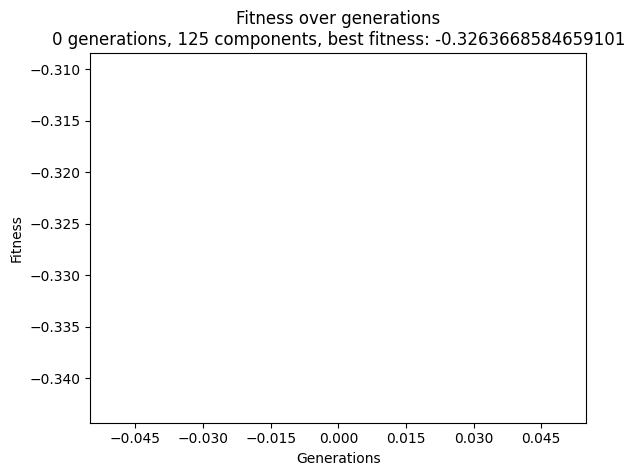

In [2]:
pop_size = 100
fixed_components = 125
crossp = 0.9
mutp = 0.0001

tolerance = 0.0001
target = -0.337
n_best = 50
ga = fixed_size_GA(pop_size,fixed_components,crossp,mutp)
solution = ga.run(tolerance,target,n_best)[0]


In [3]:

df = pd.read_excel("datasets/Dataset_2.xlsx",sheet_name="preproc")
X = (df.iloc[:,14:]).values
y = (df.iloc[:,7]).values


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR


NRMSEPiqrscorer = make_scorer(NRMSEPiqr)



trials = 100
random_cv = np.random.seed(777)
seeds = np.random.choice(trials + 1, size=trials, replace= False)
ripartition = 0.75
final_results_pls = []
alpha = 0.00122457013067159

predictions_pls = []
result_NRMSEP_pls = []
NRMSE = []
total_time = 0
for i in range(trials):
    X_train, X_test, Y_train, Y_test = train_test_split(X[:, np.where(solution == 1)[0]], y, test_size=ripartition, random_state=seeds[i])
    pls = PLSRegression(n_components=59)
            
    start_time = time.time()
    pls.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds
        
    # Make predictions using the testing set
    Y_pred_pls = pls.predict(X_test)

        
    NRMSE.append(NRMSEPiqr(Y_test, Y_pred_pls))
    total_time+=elapsed_time
        
    for k in range(len(Y_pred_pls)):

      predictions_pls.append({"Ripartition":str(ripartition *100 ),
                        "NRMSEPiqr": NRMSEPiqr(Y_test, Y_pred_pls),
                        "Training time": elapsed_time, 
                        "alpha": alpha, 
                        "Seed": seeds[i],
                          "Prediction": Y_pred_pls[k], 
                          "Actual": Y_test[k] })
        
    result_NRMSEP_pls.append({"Ripartition":str(ripartition *100 ),
                        "NRMSEPiqr": NRMSEPiqr(Y_test, Y_pred_pls),
                        "Training time": elapsed_time, 
                        "alpha": alpha, 
                        "Seed": seeds[i],
        })
final_results_pls.append({"Test size(%)": str(ripartition *100 ),
                          "Mean NRMSEPiqr":np.mean(NRMSE), 
                          "Var NRMSEPiqr": np.var(NRMSE),
                          "Mean Training Time (sec)":total_time/trials, 
                          "alpha": alpha })
       


In [4]:
print(final_results_pls)

[{'Test size(%)': '75.0', 'Mean NRMSEPiqr': np.float64(0.3263668584659101), 'Var NRMSEPiqr': np.float64(0.00010022295204932036), 'Mean Training Time (sec)': 0.03091782093048096, 'alpha': 0.00122457013067159}]


In [5]:
waves = df.iloc[:,14:].columns[np.where(solution == 1)[0]]
print(waves)

with open("GA_Fixed_75_Bands.txt","w") as f:
    for wave in waves:
        f.write(str(wave)+"\n")

Index([ 379.5,  435.5,  447.5,  459.5,  511.5,  523.5,  547.5,  567.5,  583.5,
        619.5,
       ...
       2311.5, 2327.5, 2351.5, 2359.5, 2431.5, 2451.5, 2459.5, 2479.5, 2483.5,
       2487.5],
      dtype='object', length=125)
